# PDE-FIND for the Quantum Harmonic Oscillator

By Samuel Rudy, 2016

This notebook demonstrates PDE-FIND on the schrodinger equation with a parabolic well potential.  
$$
iu_t = \frac{-1}{2}u_{xx} + \frac{x^2}{2}u
$$
We assume full knowledge of the complex wave function rather than just the squared magnitude and also know that there is a potenital function $\frac{x^2}{2}$, but it is unknown if or how it appears in the PDE.

In [1]:
%pylab inline
pylab.rcParams['figure.figsize'] = (12, 8)
import numpy as np 
from mpl_toolkits.mplot3d import Axes3D
from PDE_FIND import *
import scipy.io as sio

Populating the interactive namespace from numpy and matplotlib


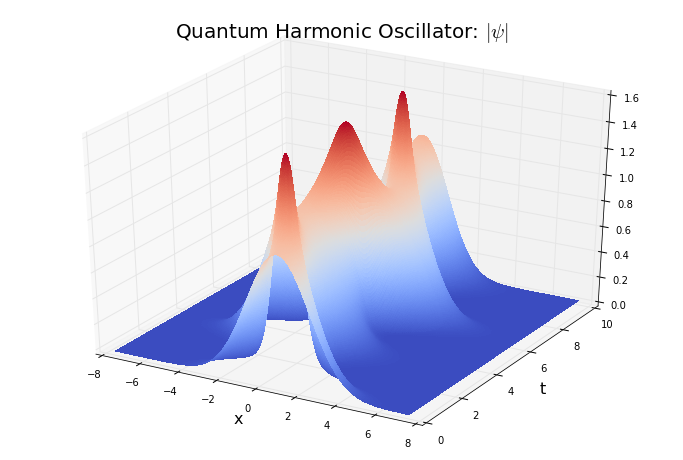

In [2]:
# Load data - solution to schrodinger in parabolic well
data = sio.loadmat('./canonicalPDEs/harmonic_osc.mat')
u = data['usol']
x = data['x'][0]
t = data['t'][:,0]
dt = t[1] - t[0]
dx = x[1] - x[0]
n = len(x)
m = len(t)
potential = np.vstack([0.5*np.power(x,2).reshape((1,n)) for _ in range(m)])

X, T = np.meshgrid(x, t)
fig = figure()
ax = fig.gca(projection='3d')
surf = ax.plot_surface(X, T, abs(u), rstride=1, cstride=1, cmap=cm.coolwarm,
    linewidth=0, antialiased=False)
title(r'Quantum Harmonic Oscillator: $|\psi|$', fontsize = 20)
xlabel('x', fontsize = 16)
ylabel('t', fontsize = 16)

## Build Library of Candidate Terms

We first differentiate the data along the spatial and temporal directions and construct a library of terms including nonlinearities and partial derivatives.  The matrix Theta is constructed so that each column is a potential term in the PDE, listed below.

In [3]:
ut = np.zeros((m,n), dtype=np.complex64)
ux = np.zeros((m,n), dtype=np.complex64)
uxx = np.zeros((m,n), dtype=np.complex64)
uxxx = np.zeros((m,n), dtype=np.complex64)

for i in range(n):
    ut[:,i] = FiniteDiff(u[:,i], dt, 1)
for i in range(m):
    ux[i,:] = FiniteDiff(u[i,:], dx, 1)
    uxx[i,:] = FiniteDiff(u[i,:], dx, 2)
    uxxx[i,:] = FiniteDiff(u[i,:], dx, 3)
    
ut = np.reshape(ut, (n*m,1), order='F')
ux = np.reshape(ux, (n*m,1), order='F')
uxx = np.reshape(uxx, (n*m,1), order='F')
uxxx = np.reshape(uxxx, (n*m,1), order='F')
X_ders = np.hstack([np.ones((n*m,1)),ux,uxx,uxxx])
X_data = np.hstack([np.reshape(u, (n*m,1), order='F'), 
                    np.reshape(abs(u), (n*m,1), order='F'), 
                    np.reshape(potential, (n*m,1), order='F')])
derivatives_description = ['','u_{x}','u_{xx}', 'u_{xxx}']

X, descr = build_Theta(X_data, X_ders, derivatives_description, 2, data_description = ['u','|u|','V'])
descr

['',
 'u_{x}',
 'u_{xx}',
 'u_{xxx}',
 '|u|V',
 'V^2',
 '|u|^2',
 'u',
 'u|u|',
 'V',
 'uV',
 '|u|',
 'u^2',
 '|u|Vu_{x}',
 'V^2u_{x}',
 '|u|^2u_{x}',
 'uu_{x}',
 'u|u|u_{x}',
 'Vu_{x}',
 'uVu_{x}',
 '|u|u_{x}',
 'u^2u_{x}',
 '|u|Vu_{xx}',
 'V^2u_{xx}',
 '|u|^2u_{xx}',
 'uu_{xx}',
 'u|u|u_{xx}',
 'Vu_{xx}',
 'uVu_{xx}',
 '|u|u_{xx}',
 'u^2u_{xx}',
 '|u|Vu_{xxx}',
 'V^2u_{xxx}',
 '|u|^2u_{xxx}',
 'uu_{xxx}',
 'u|u|u_{xxx}',
 'Vu_{xxx}',
 'uVu_{xxx}',
 '|u|u_{xxx}',
 'u^2u_{xxx}']

## Solve for PDE

Now that the linear system is constructed we look for a sparse solution.  Below, the result has the correct sparsity pattern (the right terms in the PDE).  Though they should not have real components, a threshold after identifying the PDE would eliminate those.

In [4]:
# Solve with STRidge
w = TrainSTRidge(X,ut,10**-5,10)
print "PDE derived using STRidge"
print_pde(w, descr)

PDE derived using STRidge
u_t = (0.000006 +0.498821i)u_{xx}
    + (0.000012 -0.997386i)uV
   


In [5]:
err = abs(np.array([(1j*(0.5-0.498821)+0.000006)*100/0.5, (1j*(1-0.997386)+0.000012)*100]))
print "Error using PDE-FIND to identify the Schrodinger equation:\n"
print "Mean parameter error:", mean(err), '%'
print "Standard deviation of parameter error:", std(err), '%'

Error using PDE-FIND to identify the Schrodinger equation:

Mean parameter error: 0.2486029039 %
Standard deviation of parameter error: 0.0127998504848 %


## Identifying the PDE with added noise

Now we try to identify the same PDE but with artificially added noise.  We take 1 percent of the standard deviation of the solution and add in noise with that magnitude.  The noisy solution is then differentiated using polynomials rather than finite differences and passed into PDE-FIND.  We again find the correct PDE, in terms of sparsity, this time with slightly larger error.

In [6]:
numpy.random.seed(0)
un = u + 0.01/np.sqrt(2)*(std(real(u))*np.random.randn(m,n) + 1j*std(imag(u))*np.random.randn(m,n))

In [7]:
width_x = 10
width_t = 10
deg = 6

m2 = m-2*width_t
n2 = n-2*width_x

utn = np.zeros((m2,n2), dtype=np.complex64)
uxn = np.zeros((m2,n2), dtype=np.complex64)
uxxn = np.zeros((m2,n2), dtype=np.complex64)
uxxxn = np.zeros((m2,n2), dtype=np.complex64)

for i in range(n2):
    utn[:,i] = PolyDiff(real(un[:,i+width_x]), dt*np.arange(m), deg = deg, width = width_t)[:,0]
    utn[:,i] = utn[:,i]+1j*PolyDiff(imag(un[:,i+width_x]), dt*np.arange(m), deg = deg, width = width_t)[:,0]

for i in range(m2):
    x_derivatives = PolyDiff(real(un[i+width_t,:]), dx*np.arange(n), deg = deg, diff = 3, width = width_x)
    x_derivatives = x_derivatives+1j*PolyDiff(imag(un[i+width_t,:]), dx*np.arange(n), deg = deg, diff = 3, width = width_x)
    uxn[i,:] = x_derivatives[:,0]
    uxxn[i,:] = x_derivatives[:,1]
    uxxxn[i,:] = x_derivatives[:,2]

utn = np.reshape(utn, (n2*m2,1), order='F')
uxn = np.reshape(uxn, (n2*m2,1), order='F')
uxxn = np.reshape(uxxn, (n2*m2,1), order='F')
uxxxn = np.reshape(uxxxn, (n2*m2,1), order='F')
Xn_ders = np.hstack([np.ones((n2*m2,1)),uxn,uxxn,uxxxn])
Xn_data = np.hstack([np.reshape(un[width_t:m-width_t,width_x:n-width_x], (n2*m2,1), order='F'),
                     np.reshape(abs(un[width_t:m-width_t,width_x:n-width_x]), (n2*m2,1), order='F'),
                     np.reshape(potential[width_t:m-width_t,width_x:n-width_x], (n2*m2,1), order='F')])
derivatives_description = ['','u_{x}','u_{xx}', 'u_{xxx}']

Xn, _ = build_Theta(Xn_data, Xn_ders, derivatives_description, 2)

In [8]:
# Solve with STRidge
lam = 10**-5
d_tol = 10
w = TrainSTRidge(Xn,utn,lam,d_tol)
print "PDE derived using STRidge"
print_pde(w, descr)

PDE derived using STRidge
u_t = (0.000087 +0.416703i)u_{xx}
    + (-0.000475 -1.027185i)uV
   


In [9]:
err = abs(np.array([(1j*(0.5-0.498821)+0.000087)*100/0.5, (1j*(1-0.997386)+0.000475)*100]))
print "Error using PDE-FIND to identify the Schrodinger equation with added noise:\n"
print "Mean parameter error:", mean(err), '%'
print "Standard deviation of parameter error:", std(err), '%'

Error using PDE-FIND to identify the Schrodinger equation with added noise:

Mean parameter error: 0.251060883673 %
Standard deviation of parameter error: 0.0146197704967 %
